In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

import os
import time

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image

tf.__version__

'2.4.1'

In [11]:
# DATA_DIR = '/home/jackon/captcha-tensorflow/images/char-4-epoch-6/train'  # 30241 images. validate accuracy: 87.6%
DATA_DIR = './images/char-4-epoch-1/train'  # 302410 images. validate accuracy: 98.8%
H, W, C = 100, 120, 3
N_LABELS = 10
D = 4

In [12]:
def parse_filepath(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        label, _ = filename.split("_")
        return label
    except Exception as e:
        print('error to parse %s. %s' % (filepath, e))
        return None, None

In [13]:
# create a pandas data frame of images, age, gender and race
files = glob.glob(os.path.join(DATA_DIR, "*.png"))
attributes = list(map(parse_filepath, files))

df = pd.DataFrame(attributes)
df['file'] = files

df.columns = ['label', 'file']
df = df.dropna()
df.head()

,label,file
0,7564,./images/char-4-epoch-1/train/7564_544373fa-72...
1,6815,./images/char-4-epoch-1/train/6815_1d47ac57-84...
2,8476,./images/char-4-epoch-1/train/8476_58352ad2-03...
3,7218,./images/char-4-epoch-1/train/7218_0c38d5a2-27...
4,2567,./images/char-4-epoch-1/train/2567_0c2f81ac-4a...


In [14]:
p = np.random.permutation(len(df))
train_up_to = int(len(df) * 0.7)
train_idx = p[:train_up_to]
test_idx = p[train_up_to:]

# split train_idx further into training and validation set
train_up_to = int(train_up_to * 0.7)
train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]

print('train count: %s, valid count: %s, test count: %s' % (
    len(train_idx), len(valid_idx), len(test_idx)))

train count: 2469, valid count: 1059, test count: 1512


In [15]:
from tensorflow.keras.utils import to_categorical
from PIL import Image


def get_data_generator(df, indices, for_training, batch_size=16):
    images, labels = [], []
    while True:
        for i in indices:
            r = df.iloc[i]
            file, label = r['file'], r['label']
            im = Image.open(file)
#             im = im.resize((H, W))
            im = np.array(im) / 255.0
            images.append(np.array(im))
            labels.append(np.array([np.array(to_categorical(int(i), N_LABELS)) for i in label]))
            if len(images) >= batch_size:
#                 print(np.array(images), np.array(labels))
                yield np.array(images), np.array(labels)
                images, labels = [], []
        if not for_training:
            break

In [16]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model

input_layer = tf.keras.Input(shape=(H, W, C))
x = layers.Conv2D(32, 3, activation='relu')(input_layer)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
# x = layers.Dropout(0.5)(x)

x = layers.Dense(D * N_LABELS, activation='softmax')(x)
x = layers.Reshape((D, N_LABELS))(x)

model = models.Model(inputs=input_layer, outputs=x)

model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics= ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 120, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 98, 118, 32)       896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 59, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 57, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 28, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 26, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 13, 64)        0     

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint

batch_size = 64
valid_batch_size = 64
train_gen = get_data_generator(df, train_idx, for_training=True, batch_size=batch_size)
valid_gen = get_data_generator(df, valid_idx, for_training=True, batch_size=valid_batch_size)

callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss')
]

history = model.fit(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=5,
#                     callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)

Epoch 1/5
38/38 [==============================] - 22s 563ms/step - loss: 2.3270 - accuracy: 0.0991 - val_loss: 2.3022 - val_accuracy: 0.1143
Epoch 2/5
38/38 [==============================] - 21s 561ms/step - loss: 2.3000 - accuracy: 0.1163 - val_loss: 2.2908 - val_accuracy: 0.1418
Epoch 3/5
38/38 [==============================] - 21s 558ms/step - loss: 2.2398 - accuracy: 0.1823 - val_loss: 2.0104 - val_accuracy: 0.3452
Epoch 4/5
38/38 [==============================] - 21s 562ms/step - loss: 1.7892 - accuracy: 0.3930 - val_loss: 1.5565 - val_accuracy: 0.4551
Epoch 5/5
38/38 [==============================] - 21s 563ms/step - loss: 1.3452 - accuracy: 0.5320 - val_loss: 1.3474 - val_accuracy: 0.5378


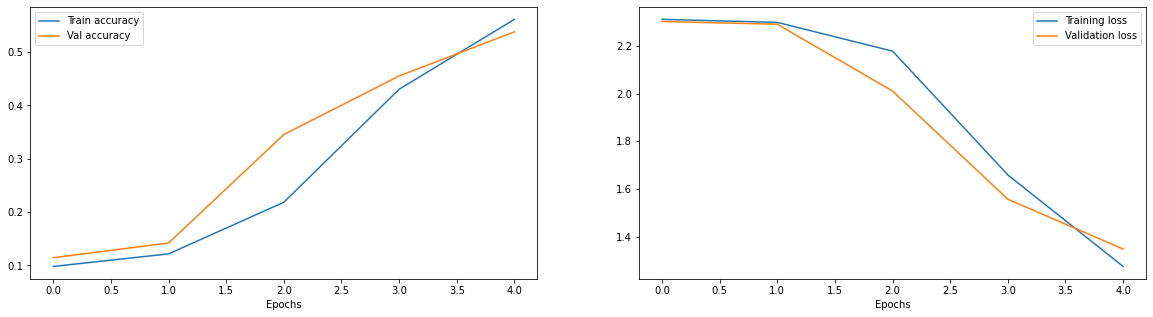

In [18]:
def  plot_train_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))

    axes[0].plot(history.history['accuracy'], label='Train accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend() 

    axes[1].plot(history.history['loss'], label='Training loss')
    axes[1].plot(history.history['val_loss'], label='Validation loss')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

plot_train_history(history)

In [19]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
dict(zip(model.metrics_names, model.evaluate(test_gen, steps=len(test_idx)//128)))

11/11 [==============================] - 3s 288ms/step - loss: 1.3495 - accuracy: 0.5375


{'loss': 1.3495068550109863, 'accuracy': 0.5374644994735718}

In [20]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
x_test, y_test = next(test_gen)

y_pred = model.predict_on_batch(x_test)

y_true = tf.math.argmax(y_test, axis=-1)
y_pred = tf.math.argmax(y_pred, axis=-1)

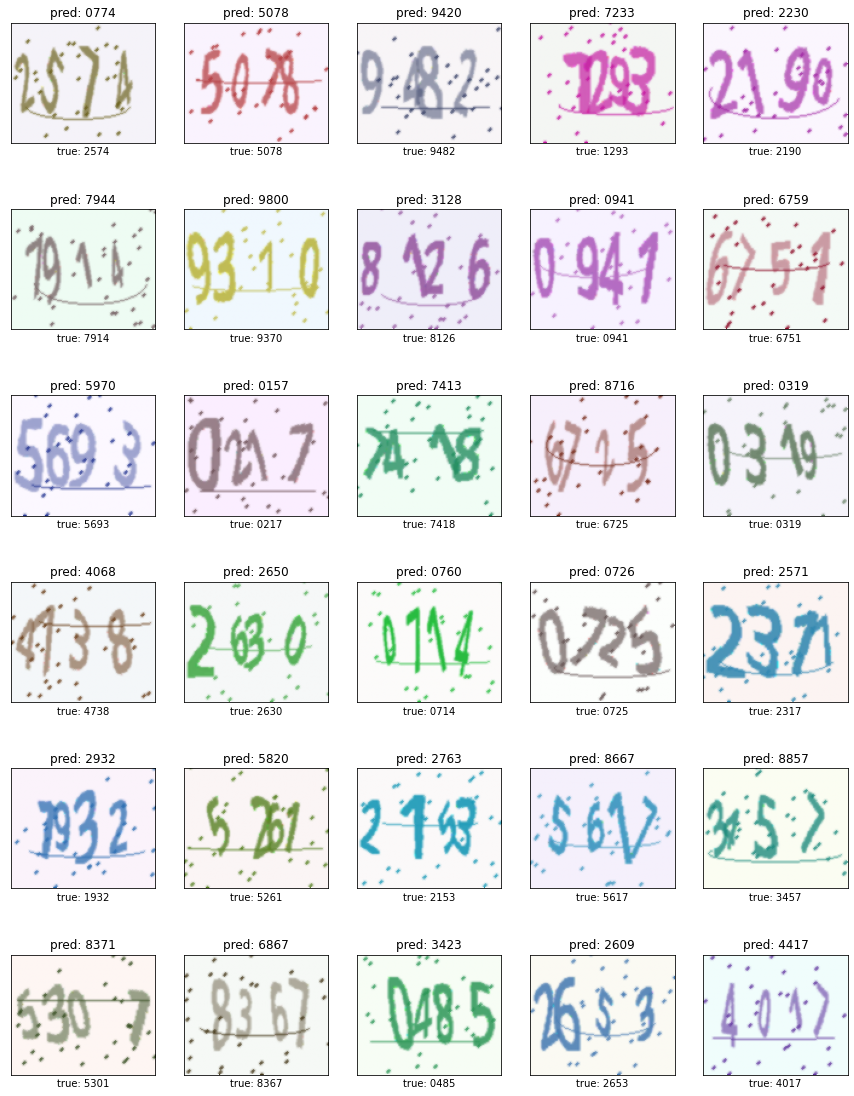

In [21]:
import math
n = 30
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(x_test[img_idx])
    ax.set_title('pred: {}'.format(
        ''.join(map(str, y_pred[img_idx].numpy()))))
    ax.set_xlabel('true: {}'.format(
        ''.join(map(str, y_true[img_idx].numpy()))))
    ax.set_xticks([])
    ax.set_yticks([])